## Постановка задачи
Необходимо придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:
* закон смещения Вина, 
* закон Стефана-Больцмана, 
* спектральный анализ. 

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным. 

В нашем распоряжении следующие характеристики:

* Относительная светимость L/Lo — светимость звезды относительно Солнца;
* Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца;
* Абсолютная звёздная величина 
* Mv — физическая величина, характеризующая блеск звезды;
* Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа;

* Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

| Тип звезды                        | Номер соответствующий типу |
|-----------------------------------|----------------------------|
| Коричневый карлик                 |   0   |
| Красный карлик                    |   1   | 
| Белый карлик                      |   2   |
| Звёзды главной последовательности |   0   |
| Сверхгигант                       |   1   | 
| Гипергигант                       |   2   |

*Задача*: разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

In [2]:
!pip install phik

     |████████████████████████████████| 679 kB 2.2 MB/s eta 0:00:01


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil

import phik
from phik.report import plot_correlation_matrix
from phik import report

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer

import tqdm

In [4]:
def info(df):

    display('------------------------------------------------------------------------')
    display('********************** Размер набора данных ****************************')
    display(f'Набор данных сподержит: {df.shape[1]} признаков, включая целевой')
    display(f'                     и: {df.shape[0]} наблюдений')
    display('------------------------------------------------------------------------')


    display('**************** 10 случайных наблюдений набора данных *****************')
    display(df.sample(10))
    display('------------------------------------------------------------------------')


    display('********************** Информация о наборе данных **********************')
    display(df.info())
    display('------------------------------------------------------------------------')


    display('********* Основные статистические характеристики набора данных *********')
    display(df.describe())
    display('------------------------------------------------------------------------')

In [5]:
def spread(column_list, df):

    for column in column_list:

        display('---------------------------------------------------------------------------------')
        display(f'************************** Признак {column} ***************************')
        df.boxplot(column=column,
                   vert=False,
                   figsize=(12,9),
                   rot=90,
                   fontsize=15)
        plt.title(f'Диаграмма размаха признака: {column}',
                  fontsize = 20)
        plt.show()

        df[column].plot(kind='hist',
                        bins=100,
                        grid=True,
                        figsize=(12,9),
                        fontsize=15)
        plt.title(f'Гистограмма признака: {column}',
                  fontsize = 20)
        plt.xlabel(column,fontsize = 15)
        plt.ylabel('Количество наблюдений',fontsize = 15)

        plt.show()

In [6]:
def uniqueness(colomn_list, df):
    # Просмотр уникальных значений
    for column in colomn_list:
        display(f'Количество уникальных значений признака {column}: {df[column].nunique()}')

        display(f'Уникальные значения пирзнака {column}:')
        display((df[column].unique()).tolist())
        display('------------------------------------------------------------------------')

## Загрузка данных

In [7]:
df = pd.read_csv('/datasets/6_class.csv', index_col = 0)
info(df)

'------------------------------------------------------------------------'

'********************** Размер набора данных ****************************'

'Набор данных сподержит: 6 признаков, включая целевой'

'                     и: 240 наблюдений'

'------------------------------------------------------------------------'

'**************** 10 случайных наблюдений набора данных *****************'

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
130,3095,0.00019,0.4920,10.870,1,Red
226,9892,593900.00000,80.0000,-7.262,4,Blue
224,16787,246730.00000,62.0000,-6.350,4,Blue
18,3192,0.00362,0.1967,13.530,1,Red
153,16390,1278.00000,5.6800,-3.320,3,Blue-white
56,3660,363000.00000,1673.0000,-11.920,5,Red
11,3129,0.01220,0.3761,11.790,1,Red
151,8945,38.00000,2.4870,0.120,3,Blue-White
95,11250,672.00000,6.9800,-2.300,3,Blue-white
34,5800,0.81000,0.9000,5.050,3,yellow-white


'------------------------------------------------------------------------'

'********************** Информация о наборе данных **********************'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


None

'------------------------------------------------------------------------'

'********* Основные статистические характеристики набора данных *********'

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


'------------------------------------------------------------------------'

In [8]:
# проверим данные на дубликаты
df.duplicated().sum()

0

In [9]:
numeric_columns = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
                   'Absolute magnitude(Mv)', 'Star type']

'---------------------------------------------------------------------------------'

'************************** Признак Temperature (K) ***************************'

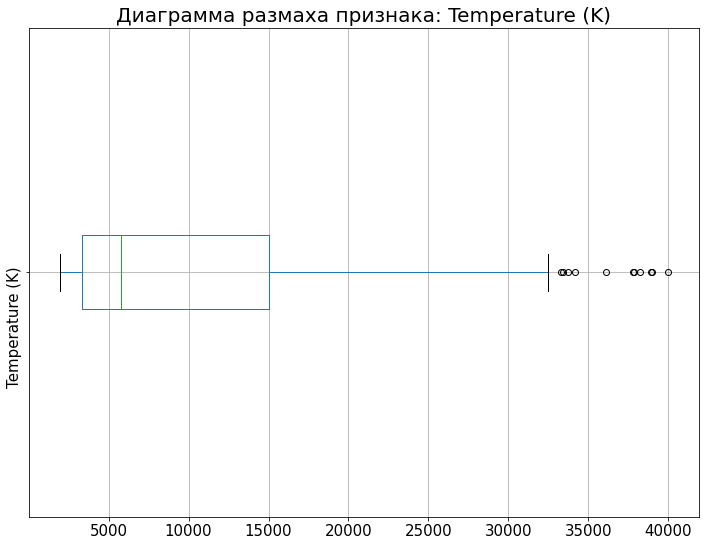

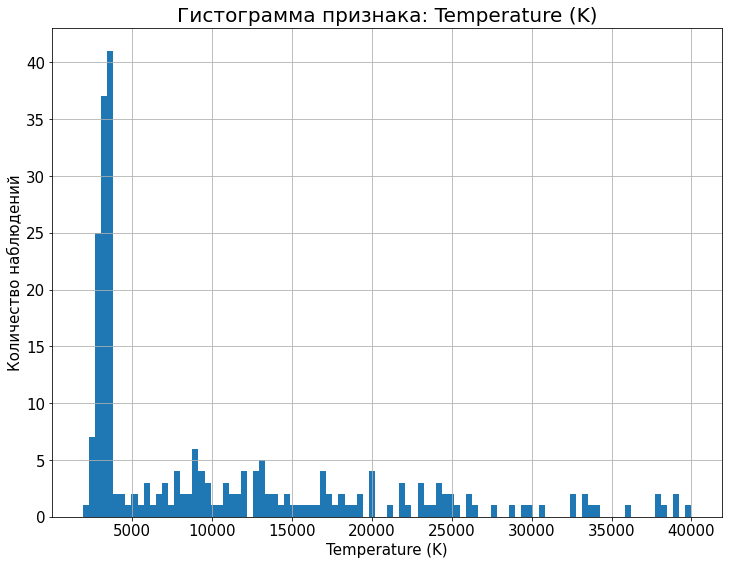

'---------------------------------------------------------------------------------'

'************************** Признак Luminosity(L/Lo) ***************************'

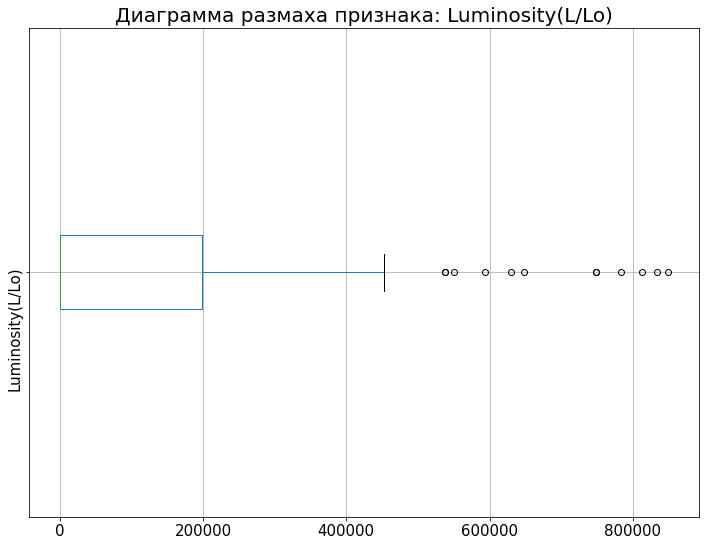

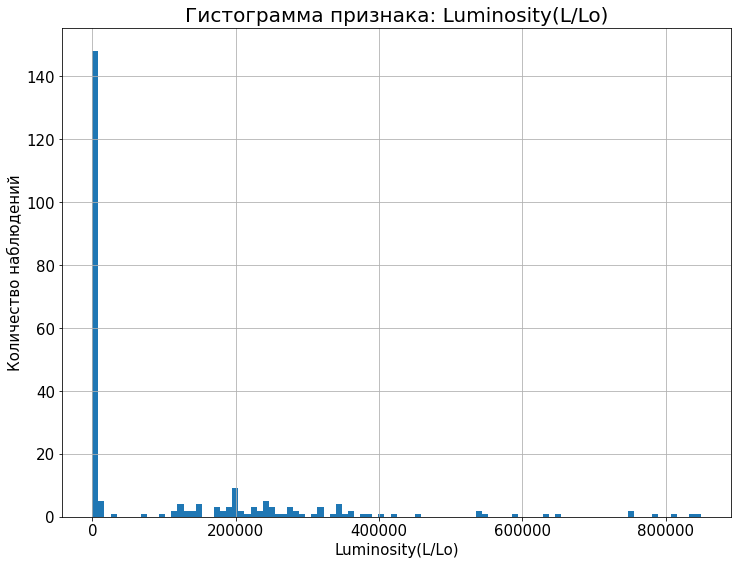

'---------------------------------------------------------------------------------'

'************************** Признак Radius(R/Ro) ***************************'

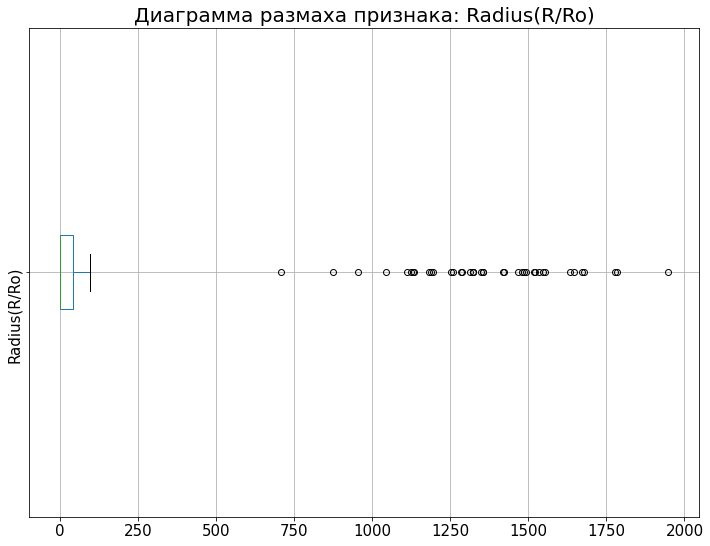

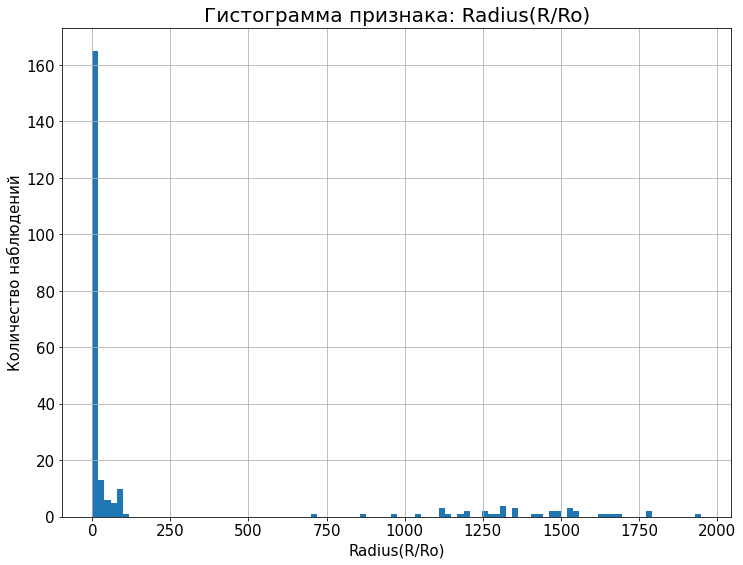

'---------------------------------------------------------------------------------'

'************************** Признак Absolute magnitude(Mv) ***************************'

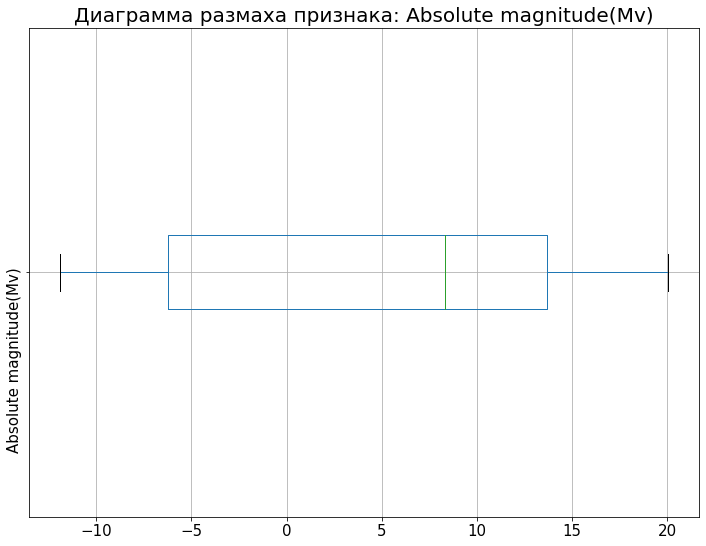

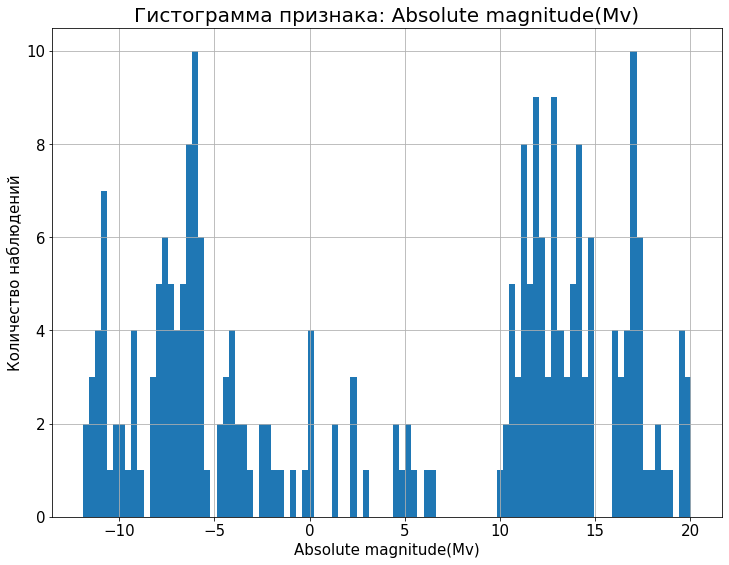

'---------------------------------------------------------------------------------'

'************************** Признак Star type ***************************'

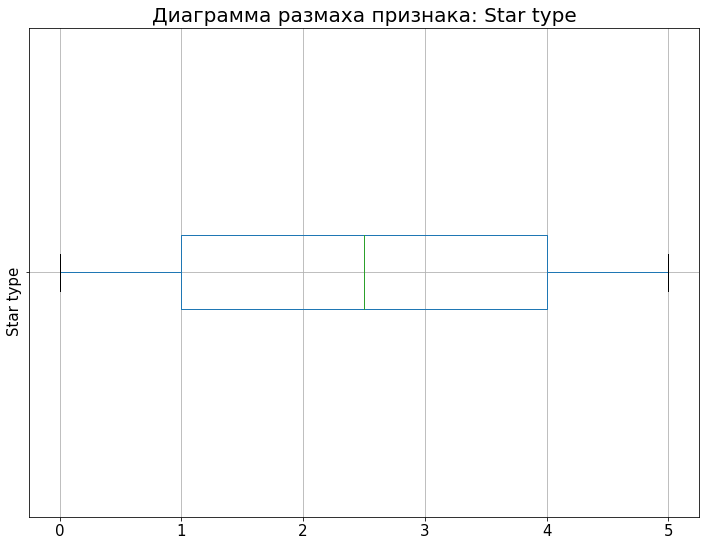

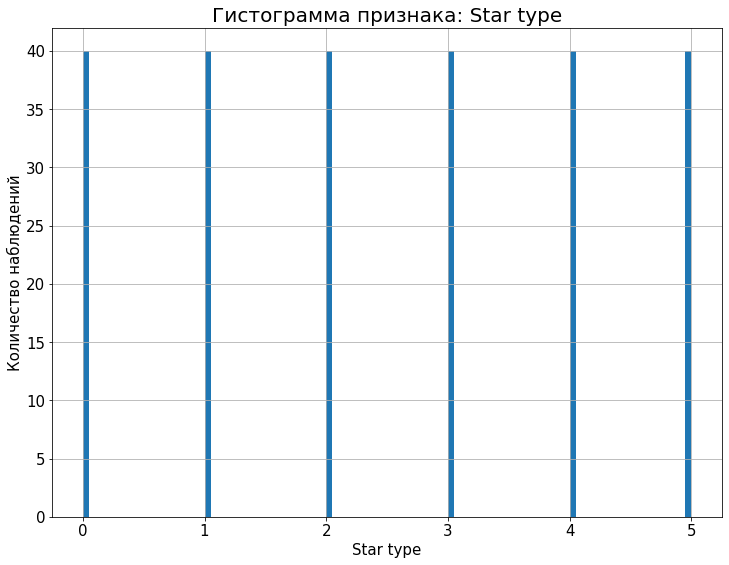

In [10]:
# Посмотрим на разброс данных
spread(numeric_columns, df)

In [11]:
cat_columns = ['Star type', 'Star color']

In [12]:
uniqueness(cat_columns, df)

'Количество уникальных значений признака Star type: 6'

'Уникальные значения пирзнака Star type:'

[0, 1, 2, 3, 4, 5]

'------------------------------------------------------------------------'

'Количество уникальных значений признака Star color: 19'

'Уникальные значения пирзнака Star color:'

['Red',
 'Blue White',
 'White',
 'Yellowish White',
 'Blue white',
 'Pale yellow orange',
 'Blue',
 'Blue-white',
 'Whitish',
 'yellow-white',
 'Orange',
 'White-Yellow',
 'white',
 'Blue ',
 'yellowish',
 'Yellowish',
 'Orange-Red',
 'Blue white ',
 'Blue-White']

'------------------------------------------------------------------------'

In [13]:
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

In [14]:
display(df.corr())

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
Temperature (K),1.000000,0.393404,0.064216,-0.420261,0.411129
Luminosity(L/Lo),0.393404,1.000000,0.526516,-0.692619,0.676845
Radius(R/Ro),0.064216,0.526516,1.000000,-0.608728,0.660975
Absolute magnitude(Mv),-0.420261,-0.692619,-0.608728,1.000000,-0.955276
Star type,0.411129,0.676845,0.660975,-0.955276,1.000000


In [15]:
display(df.loc[df['Temperature (K)'] > 32000].sort_values(by=['Temperature (K)']))

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
215,32460,173800.0,6.237,-4.36,3,Blue
232,32489,648430.0,1948.500,-10.84,5,Blue
100,33300,240000.0,12.000,-6.50,4,Blue
109,33421,352000.0,67.000,-5.79,4,Blue
49,33750,220000.0,26.000,-6.10,4,Blue
214,34190,198200.0,6.390,-4.57,3,Blue
99,36108,198000.0,10.200,-4.40,3,Blue
159,37800,202900.0,6.860,-4.56,3,Blue
239,37882,294903.0,1783.000,-7.80,5,Blue
231,38234,272830.0,1356.000,-9.29,5,Blue


In [16]:
display(df.loc[df['Luminosity(L/Lo)'] > 100000].sort_values(by=['Luminosity(L/Lo)']))

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
104,11096,112000.0,12.0,-5.910,4,Blue
113,3399,117000.0,1486.0,-10.920,5,Red
178,12100,120000.0,708.9,-7.840,5,Blue-white
46,3575,123000.0,45.0,-6.780,4,Red
111,3605,126000.0,1124.0,-10.810,5,Red
...,...,...,...,...,...,...
229,21738,748890.0,92.0,-7.346,4,Blue
227,10930,783930.0,25.0,-6.224,4,Blue
101,40000,813000.0,14.0,-6.230,4,Blue
236,30839,834042.0,1194.0,-10.630,5,Blue


In [17]:
display(df.loc[df['Radius(R/Ro)'] > 500].sort_values(by=['Radius(R/Ro)']))

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
178,12100,120000.0,708.9,-7.84,5,Blue-white
117,3625,74000.0,876.0,-10.25,5,Red
58,3752,209000.0,955.0,-11.24,5,Red
176,18000,200000.0,1045.0,-8.30,5,Blue
238,9235,404940.0,1112.0,-11.23,5,White
111,3605,126000.0,1124.0,-10.81,5,Red
234,21904,748490.0,1130.0,-7.67,5,Blue-white
179,24490,248490.0,1134.5,-8.24,5,Blue-white
52,3834,272000.0,1183.0,-9.20,5,Red
174,3600,240000.0,1190.0,-7.89,5,Red


#### Вывод

1. Набор данных содержит 6 признаков и 240 наблюдений. 

2. Набор данных содержит 6 признаков:
    * Категориальные признаки:
        * `Star type`;
        * `Star color`.
    * Количественные признаки:
        * `Luminosity(L/Lo)`;
        * `Radius(R/Ro)`;
        * `Absolute magnitude(Mv)`.
    * Целевой признак -- `Temperature (K)`.

    `Temperature (K)` - медианное значение стоит выше 5000 (К), в целом в наборе данных большинство наблюдений имеет температуру звезды примерно 3500-4000 Кельвинов, что является среднестатистической нормой температуры звёзд. Но существуют значения, которые выходят за пределы усов диаграммы размаха  (>32500 Кельвинов), не будем удалять эти значения, потому что подобная температура звёзд возможна.

    `Luminosity(L/Lo)` - большинство звёзд в наборе данных имеют низкую светимость относительно солнца.

    `Radius(R/Ro)` -  большинство наблюдений имеют меньший радиус, по сравнению с солнцем.

    `Absolute magnitude(Mv)` - признак без выбросов, который имеет бимодальное распределение, практически зеркальное в отрицательной и положительной частях графика. Меньше всего значений в диапазоне 0-5.

    `Star type` - категориальный столбец, по которому мы можем увидеть, что нам предоставили по 40 наблюдений каждого класса.

3. Пропусков и явных дубликатов в данных нет. 

4. Есть неявные дубликаты в признаке `Star color`.


## Предобработка и анализ данных

In [18]:
# неявные дубликаты
df['Star color'] = df['Star color'].replace('blue white', 'blue-white')
df['Star color'] = df['Star color'].replace(['yellow-white', 'yellowish white'], 'white-yellow')
df['Star color'] = df['Star color'].str.lower()
df['Star color'] = df['Star color'].str.strip(to_strip = None)
uniqueness(cat_columns, df)

'Количество уникальных значений признака Star type: 6'

'Уникальные значения пирзнака Star type:'

[0, 1, 2, 3, 4, 5]

'------------------------------------------------------------------------'

'Количество уникальных значений признака Star color: 12'

'Уникальные значения пирзнака Star color:'

['red',
 'blue white',
 'white',
 'yellowish white',
 'pale yellow orange',
 'blue',
 'blue-white',
 'whitish',
 'white-yellow',
 'orange',
 'yellowish',
 'orange-red']

'------------------------------------------------------------------------'

#### Вывод
По результатам предобработки данных были исправлены ошибки в столбце Star color, связанные с неявными дубликатами в словах, что позволило сократить количество уникальных значений с 19 до 12 штук.

### Корреляция

interval columns not set, guessing: ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Star type']


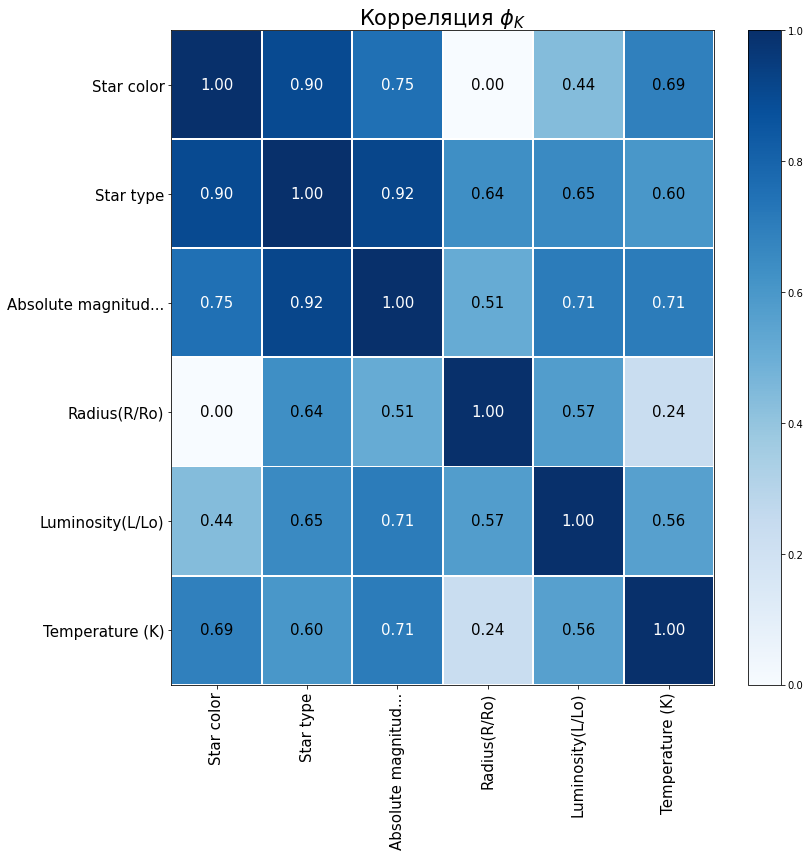

In [19]:
# Корреляция Phik

phik_overview = df.phik_matrix()
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Blues",
                        title=r"Корреляция $\phi_K$",
                        fontsize_factor=1.5,
                        figsize=(12, 12))
plt.tight_layout()
plt.show()

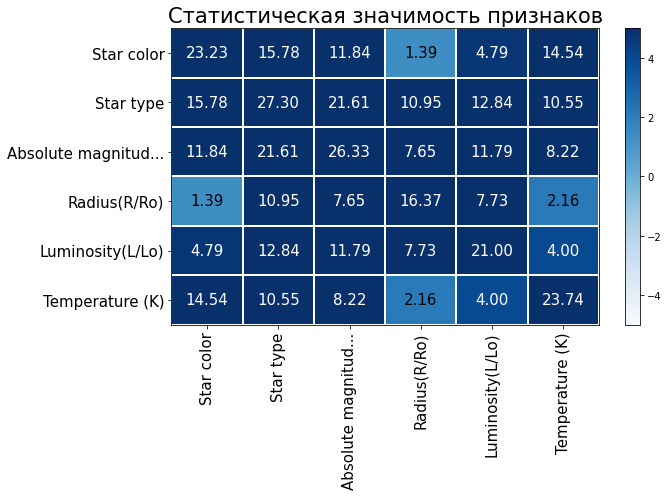

In [20]:
# Статзначимость

significance_overview = df.significance_matrix(interval_cols=['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Star type'])
plot_correlation_matrix(significance_overview.fillna(0).values,
                        x_labels=significance_overview.columns,
                        y_labels=significance_overview.index,
                        vmin=-5, vmax=5, title="Статистическая значимость признаков",
                        usetex=False, fontsize_factor=1.5, figsize=(10, 7), color_map="Blues")
plt.tight_layout()

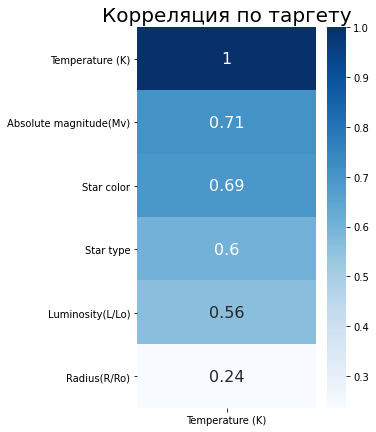

In [21]:
# Корреляция целевого признака
plt.figure(figsize=(4, 7))
sns.heatmap(phik_overview.sort_values(by = 'Temperature (K)',
                                      ascending=False)[['Temperature (K)']],
                                      cmap='Blues', annot=True,
                                      annot_kws={'size':16},
                                      fmt='.2g')
plt.title('Корреляция по таргету', fontsize=20)
plt.show()

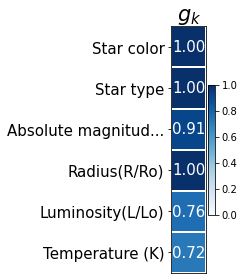

In [22]:
global_correlation, global_labels = df.global_phik(interval_cols=numeric_columns)

plot_correlation_matrix(global_correlation,
                        x_labels=[''],
                        y_labels=global_labels,
                        vmin=0,
                        vmax=1,
                        figsize=(3.5,4),
                        color_map="Blues",
                        title=r"$g_k$",
                        fontsize_factor=1.5)
plt.tight_layout()

#### Вывод
Мультикорреляция между столбцом `Star type` и `Absolute magnitude(Mv)`, равная 90% по корреляции phik. Но статзначимость равная- 21,61, поэтому оставим эти оба этих признака.

Зависимость целевого признака с признаками:

`Luminosity(L/Lo)` - 56% корреляция. Относительная светимость зависит от температуры.

`Absolute magnitude(Mv)` - 71% корреляция. Абсолютная звёздная величина схожа с понятием относительная светимость.

`Star color` - 69% корреляция. Главным фактором температуры звезды является его цвет.

`Star type` - 60% корреляцияс нашим признаком. Всё просто у нас есть пять основных типов звёзд и по ним возможно понять их температуру, с точки зрения статистики и наблюдений.

`Radius(R/Ro)` - 24%. 

## Построение базовой нейронной сети

### Подготовка данных

In [30]:
# Разделим нашу выборку
X_train, X_test, y_train, y_test = train_test_split(df.drop('Temperature (K)', axis = 1),
                                                    df['Temperature (K)'],
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=1)

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(192, 5)

(48, 5)

(192,)

(48,)

In [31]:
numeric_features = ['Luminosity(L/Lo)', 'Radius(R/Ro)',
                   'Absolute magnitude(Mv)']
cat_features = ['Star type', 'Star color']

In [32]:
col_transformer = ColumnTransformer(
                        transformers=[
                            ('scaler', StandardScaler(), numeric_features),
                            ('ohe', OneHotEncoder(sparse=False), cat_features)],
                                remainder="passthrough"
                                  )

col_transformer.fit(df.drop('Temperature (K)', axis=1))
X_train = col_transformer.transform(X_train)
X_test = col_transformer.transform(X_test)

In [34]:
X_train[0]

array([-0.59862356, -0.45920992,  1.11674535,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

In [35]:
# Перевод выборки в тензоры
X_train = torch.FloatTensor(np.array(X_train))
X_test = torch.FloatTensor(np.array(X_test))
y_train = torch.FloatTensor(np.array(y_train))
y_test = torch.FloatTensor(np.array(y_test))

In [36]:
X_train[0]

tensor([-0.5986, -0.4592,  1.1167,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000])

### Создание нейросети

In [26]:
# Создание ПНС
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons,drop_out):
            super(Net, self).__init__()

            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.act1 = nn.ReLU()
            self.dp2 = drop_out
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.act2 = nn.ReLU()
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)

        return x

In [27]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 15
n_hidden_neurons_2 = 10
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, drop_out=0)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss = nn.MSELoss()

In [28]:
dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataset_test = torch.utils.data.TensorDataset(X_test, y_test)

train_dataloader = DataLoader(dataset_train, batch_size=40, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=40, num_workers=0)

In [29]:
class CustomEarlyStopping():
    """
    Ранняя остановка, чтобы остановить тренировку, когда потеря не улучшается после определенной эпохи.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: сколько эпох ждать, прежде чем остановиться, когда потеря не улучшается
        :param min_delta: минимальная разница между loss/метриками, если улучшений нет, то остановим обучение
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [30]:
def fit_net(net):
    early_stopping = CustomEarlyStopping(patience=5, min_delta=20)

    num_epochs = 100001
    val_loss = []
    train_loss = []
    for epoch in range(num_epochs):
        net.train()
        train_loss_batches = []
        for batch in train_dataloader:
            data_train, temperature_train = batch
            optimizer.zero_grad()

            preds = net.forward(data_train).flatten()

            loss_value = torch.sqrt(loss(preds, temperature_train))
            loss_value.backward()
            optimizer.step()
            loss_value = loss_value.detach().numpy().reshape([-1])
        train_loss_batches.append(loss_value)
        if epoch % 200 == 0:
            predicted_temp = []
            with torch.no_grad():
                net.eval()
                for batch in test_dataloader:
                    data_test, temperature_test = batch

                    test_preds = net.forward(data_test).flatten()
                    predicted_temp.append(test_preds)
                    RMSE_loss = torch.sqrt(loss(test_preds, temperature_test))

            predicted_temp = torch.cat(predicted_temp).detach().numpy()
            RMSE = mean_squared_error(y_test, predicted_temp, squared=False)
            early_stopping(RMSE)
            if early_stopping.counter == 0:
                best_rmse = RMSE
                best_predicted_temp = predicted_temp
                val_loss.append(best_rmse)
                train_loss.append(np.mean(train_loss_batches))
            print(f"epoch:{epoch}, RMSE test: {RMSE}")

            if early_stopping.early_stop:
                print('Early Stoppning!!!')
                print(f'Best RMSE test {best_rmse}')
                try:rmse_optimizers.append(round(best_rmse, 2))
                except: None
                break
    return val_loss, train_loss, predicted_temp

In [31]:
_,_,predicted_temp = fit_net(net)

epoch:0, RMSE test: 15201.3037109375
epoch:200, RMSE test: 13995.9462890625
epoch:400, RMSE test: 9472.173828125
epoch:600, RMSE test: 7629.2119140625
epoch:800, RMSE test: 7103.06884765625
epoch:1000, RMSE test: 6591.98193359375
epoch:1200, RMSE test: 6133.720703125
epoch:1400, RMSE test: 5767.48193359375
epoch:1600, RMSE test: 5514.2626953125
epoch:1800, RMSE test: 5350.83984375
epoch:2000, RMSE test: 5250.98828125
epoch:2200, RMSE test: 5174.19580078125
epoch:2400, RMSE test: 5112.6064453125
epoch:2600, RMSE test: 5053.67529296875
epoch:2800, RMSE test: 4998.7685546875
epoch:3000, RMSE test: 4953.3662109375
epoch:3200, RMSE test: 4909.001953125
epoch:3400, RMSE test: 4876.65966796875
epoch:3600, RMSE test: 4846.06201171875
epoch:3800, RMSE test: 4821.24853515625
INFO: Early stopping counter 1 of 5
epoch:4000, RMSE test: 4802.21435546875
epoch:4200, RMSE test: 4780.5986328125
epoch:4400, RMSE test: 4755.47021484375
INFO: Early stopping counter 1 of 5
epoch:4600, RMSE test: 4747.38671

In [32]:
def fact_forecast(test_preds, y_test):

    '''Функция для визуализации качества регрессии "Факт-прогноз"'''

    y1 = torch.FloatTensor(test_preds)
    y1 = y1.detach().numpy().reshape([-1])
    y2 = y_test.detach().numpy().reshape([-1])
    x = np.arange(len(y1))

    fig,ax = plt.subplots()
    fig.set_figwidth(18)
    fig.set_figheight(8)
    ax.set_xticks(x)
    fact = ax.bar(x, y2, width = 0.6, label = 'Факт')
    forecast = ax.bar(x, y1, width = 0.3, label = 'Прогноз')
    ax.legend()
    ax.set_title('График "Факт-прогноз"', fontsize=20)
    ax.set_xlabel('Номер звезды')
    ax.set_ylabel('Температура звезды')
    plt.show()

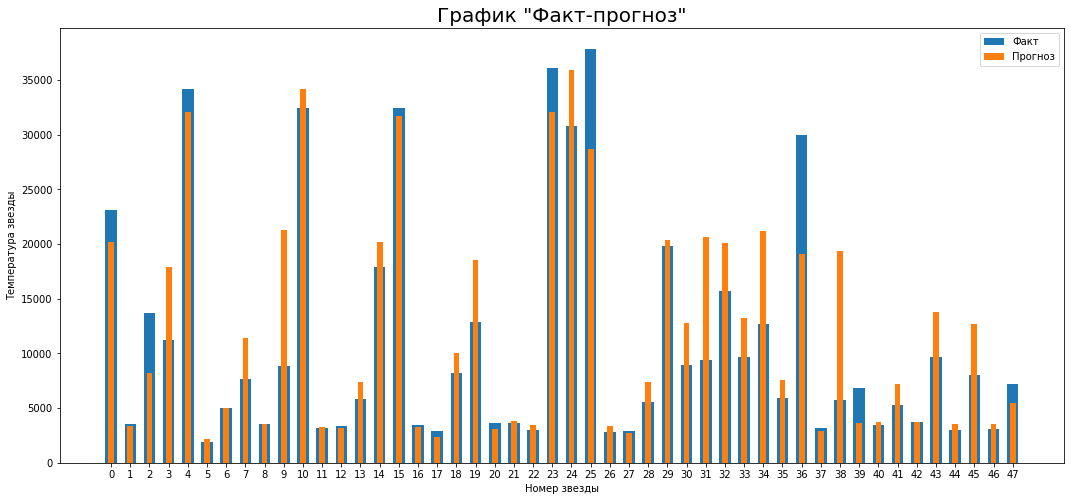

In [33]:
# Визуализация полученных значений
fact_forecast(predicted_temp, y_test)

#### Вывод
1. Обучена baseline модель без перебора параметров. 
2. Лучшая метрика RMSE до начала переобучения равна 4268. 
3. График факт-прогноз показывает,что нейросеть хорошо прогнозирует температуру звёзд с минимальным отклонением до 5000 градусов по Кельвину. Далее нейросеть начинает ошибаться, то выше правильного ответа, то ниже. Предположительно, нейросети не хватило данных, чтобы правильно научиться на таком малом количестве данных.

## Улучшение нейронной сети

In [34]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 15
n_hidden_neurons_2 = 10
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, drop_out=nn.Dropout(p=0))
optimizer1 = torch.optim.Adam(net.parameters(), lr=1e-3)
optimizer2 = torch.optim.NAdam(net.parameters(), lr=1e-2)
optimizer3 = torch.optim.Adamax(net.parameters(), lr=1e-2)
optimizer4 = torch.optim.Adamax(net.parameters(), lr=1e-3)
optimizer5 = torch.optim.Adam(net.parameters(), lr=1e-2)

optimizers = [optimizer1, optimizer2, optimizer3, optimizer4, optimizer5]

In [35]:
rmse_optimizers = []

for optimizer in optimizers:
    print(optimizer)
    print('-------------------------------------------------------------------------')
    train_dataloader = DataLoader(dataset_train, batch_size=40, shuffle=True,
                                      num_workers=0)
    test_dataloader = DataLoader(dataset_test, batch_size=40, num_workers=0)
    _,_, predicted_temp = fit_net(net)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
-------------------------------------------------------------------------
epoch:0, RMSE test: 15201.0986328125
epoch:200, RMSE test: 13887.8349609375
epoch:400, RMSE test: 9125.2978515625
epoch:600, RMSE test: 7548.7470703125
epoch:800, RMSE test: 6985.0498046875
epoch:1000, RMSE test: 6449.923828125
epoch:1200, RMSE test: 6001.26171875
epoch:1400, RMSE test: 5663.84716796875
epoch:1600, RMSE test: 5443.26708984375
epoch:1800, RMSE test: 5309.5634765625
epoch:2000, RMSE test: 5217.6943359375
epoch:2200, RMSE test: 5144.06787109375
epoch:2400, RMSE test: 5071.44873046875
epoch:2600, RMSE test: 5003.88427734375
epoch:2800, RMSE test: 4937.31298828125
epoch:3000, RMSE test: 4876.73681640625
epoch:3200, RMSE test: 4830.69921875
epoch:3400, RMSE test: 4793.89013671875
epoch:3600, RMSE test: 4761.31201171875
INFO: Early stopping counter 1 of 5
epoch:3800, RMSE test: 4746.727

In [36]:
optimizers_rmse = pd.DataFrame(data = rmse_optimizers, index = ['Adam, lr: 0.001',
                                                                'NAdam, lr: 0.01',
                                                                'Adamax, lr: 0.01',
                                                                'Adamax, lr: 0.001',
                                                                'Adam, lr: 0.01'], columns = ['RMSE'])
display(optimizers_rmse.sort_values(by='RMSE'))

,RMSE
"NAdam, lr: 0.01",4094.500000
"Adam, lr: 0.001",4614.740234
"Adamax, lr: 0.01",4727.080078
"Adam, lr: 0.01",4889.919922
"Adamax, lr: 0.001",4997.870117


In [37]:
batch_sizes = [10, 20, 50]
rmse_optimizers = []
for b_size in batch_sizes:

    print(f'batch_size - {b_size}')
    train_dataloader = DataLoader(dataset_train, batch_size=b_size, shuffle=True,
                                  num_workers=0)
    test_dataloader = DataLoader(dataset_test, batch_size=b_size, num_workers=0)
    _,_, predicted_temp = fit_net(net)

batch_size - 10
epoch:0, RMSE test: 5481.70556640625
INFO: Early stopping counter 1 of 5
epoch:200, RMSE test: 5561.56494140625
epoch:400, RMSE test: 5132.86474609375
epoch:600, RMSE test: 4992.09521484375
INFO: Early stopping counter 1 of 5
epoch:800, RMSE test: 5012.60546875
epoch:1000, RMSE test: 4936.87353515625
INFO: Early stopping counter 1 of 5
epoch:1200, RMSE test: 5003.806640625
INFO: Early stopping counter 2 of 5
epoch:1400, RMSE test: 5083.42724609375
INFO: Early stopping counter 3 of 5
epoch:1600, RMSE test: 5385.93017578125
INFO: Early stopping counter 4 of 5
epoch:1800, RMSE test: 5363.6552734375
INFO: Early stopping counter 5 of 5
INFO: Early stopping
epoch:2000, RMSE test: 5497.18798828125
Early Stoppning!!!
Best RMSE test 4936.87353515625
batch_size - 20
epoch:0, RMSE test: 5485.484375
epoch:200, RMSE test: 5461.16650390625
INFO: Early stopping counter 1 of 5
epoch:400, RMSE test: 5462.54541015625
epoch:600, RMSE test: 5342.962890625
epoch:800, RMSE test: 5270.3041992

In [38]:
bs_rmse = pd.DataFrame(data = rmse_optimizers, index = ['batch_sizes: 10',
                                                        'batch_sizes: 20',
                                                        'batch_sizes: 50'], columns = ['RMSE'])
display(bs_rmse.sort_values(by='RMSE'))

,RMSE
batch_sizes: 10,4936.870117
batch_sizes: 20,5270.299805
batch_sizes: 50,5554.100098


In [39]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 15
n_hidden_neurons_2 = 10
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, drop_out = nn.Dropout(p=0.1))
optimizer = torch.optim.NAdam(net.parameters(), lr=1e-2)
loss = nn.MSELoss()

dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataset_test = torch.utils.data.TensorDataset(X_test, y_test)

train_dataloader = DataLoader(dataset_train, batch_size=10, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=10, num_workers=0)
_,_,_ = fit_net(net)

epoch:0, RMSE test: 15197.3193359375
epoch:200, RMSE test: 4772.13623046875
epoch:400, RMSE test: 4356.15771484375
epoch:600, RMSE test: 4185.8994140625
epoch:800, RMSE test: 4106.08642578125
INFO: Early stopping counter 1 of 5
epoch:1000, RMSE test: 4109.927734375
INFO: Early stopping counter 2 of 5
epoch:1200, RMSE test: 4237.10791015625
INFO: Early stopping counter 3 of 5
epoch:1400, RMSE test: 4362.791015625
INFO: Early stopping counter 4 of 5
epoch:1600, RMSE test: 4321.814453125
INFO: Early stopping counter 5 of 5
INFO: Early stopping
epoch:1800, RMSE test: 4362.4833984375
Early Stoppning!!!
Best RMSE test 4106.08642578125


In [40]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 15
n_hidden_neurons_2 = 10
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, drop_out = nn.Dropout(p=0.3))
optimizer = torch.optim.NAdam(net.parameters(), lr=1e-2)
loss = nn.MSELoss()

dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataset_test = torch.utils.data.TensorDataset(X_test, y_test)

train_dataloader = DataLoader(dataset_train, batch_size=10, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=10, num_workers=0)
_,_,_ = fit_net(net)

epoch:0, RMSE test: 15197.6435546875
epoch:200, RMSE test: 4774.4306640625
epoch:400, RMSE test: 4211.05615234375
INFO: Early stopping counter 1 of 5
epoch:600, RMSE test: 4207.07373046875
INFO: Early stopping counter 2 of 5
epoch:800, RMSE test: 4340.57275390625
INFO: Early stopping counter 3 of 5
epoch:1000, RMSE test: 4199.18359375
epoch:1200, RMSE test: 4119.4267578125
INFO: Early stopping counter 1 of 5
epoch:1400, RMSE test: 4224.703125
INFO: Early stopping counter 2 of 5
epoch:1600, RMSE test: 4247.2333984375
INFO: Early stopping counter 3 of 5
epoch:1800, RMSE test: 4294.06640625
INFO: Early stopping counter 4 of 5
epoch:2000, RMSE test: 4257.1484375
INFO: Early stopping counter 5 of 5
INFO: Early stopping
epoch:2200, RMSE test: 4319.52490234375
Early Stoppning!!!
Best RMSE test 4119.4267578125


In [41]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 15
n_hidden_neurons_2 = 10
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, drop_out = nn.Dropout(p=0.5))
optimizer = torch.optim.NAdam(net.parameters(), lr=1e-2)
loss = nn.MSELoss()

dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataset_test = torch.utils.data.TensorDataset(X_test, y_test)

train_dataloader = DataLoader(dataset_train, batch_size=10, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=10, num_workers=0)
_,_,_ = fit_net(net)

epoch:0, RMSE test: 15195.642578125
epoch:200, RMSE test: 4629.81982421875
epoch:400, RMSE test: 4452.3115234375
epoch:600, RMSE test: 4328.14990234375
INFO: Early stopping counter 1 of 5
epoch:800, RMSE test: 4402.1787109375
epoch:1000, RMSE test: 4226.79150390625
INFO: Early stopping counter 1 of 5
epoch:1200, RMSE test: 4385.412109375
INFO: Early stopping counter 2 of 5
epoch:1400, RMSE test: 4584.2958984375
INFO: Early stopping counter 3 of 5
epoch:1600, RMSE test: 4560.5419921875
INFO: Early stopping counter 4 of 5
epoch:1800, RMSE test: 4387.40283203125
INFO: Early stopping counter 5 of 5
INFO: Early stopping
epoch:2000, RMSE test: 4568.67724609375
Early Stoppning!!!
Best RMSE test 4226.79150390625


In [42]:
# Добавление регуляризации на лучшем оптимизаторе

class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, drop_out):
            super(Net, self).__init__()

            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
            self.act1 = nn.ReLU()
            self.dp2 = drop_out
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.act2 = nn.ReLU()
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dp2(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)

        return x

In [43]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 15
n_hidden_neurons_2 = 10
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, drop_out = nn.Dropout(p=0.3))
optimizer = torch.optim.NAdam(net.parameters(), lr=1e-2)
loss = nn.MSELoss()

dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataset_test = torch.utils.data.TensorDataset(X_test, y_test)

train_dataloader = DataLoader(dataset_train, batch_size=10, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=10, num_workers=0)
_,_,_ = fit_net(net)

epoch:0, RMSE test: 15195.86328125
epoch:200, RMSE test: 4803.8837890625
epoch:400, RMSE test: 4570.5712890625
epoch:600, RMSE test: 4042.328125
INFO: Early stopping counter 1 of 5
epoch:800, RMSE test: 4166.556640625
INFO: Early stopping counter 2 of 5
epoch:1000, RMSE test: 4358.79931640625
INFO: Early stopping counter 3 of 5
epoch:1200, RMSE test: 4100.3603515625
INFO: Early stopping counter 4 of 5
epoch:1400, RMSE test: 4085.094482421875
INFO: Early stopping counter 5 of 5
INFO: Early stopping
epoch:1600, RMSE test: 4451.40234375
Early Stoppning!!!
Best RMSE test 4042.328125


In [44]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 15
n_hidden_neurons_2 = 10
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, drop_out = nn.Dropout(p=0.5))
optimizer = torch.optim.NAdam(net.parameters(), lr=1e-2)
loss = nn.MSELoss()

In [45]:
dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataset_test = torch.utils.data.TensorDataset(X_test, y_test)

train_dataloader = DataLoader(dataset_train, batch_size=40, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=40, num_workers=0)

In [46]:
val_loss, train_loss, predicted_temp = fit_net(net)

epoch:0, RMSE test: 15201.1220703125
epoch:200, RMSE test: 4390.43994140625
epoch:400, RMSE test: 4323.17822265625
epoch:600, RMSE test: 4220.46240234375
INFO: Early stopping counter 1 of 5
epoch:800, RMSE test: 4266.076171875
INFO: Early stopping counter 2 of 5
epoch:1000, RMSE test: 4299.57373046875
INFO: Early stopping counter 3 of 5
epoch:1200, RMSE test: 4431.333984375
INFO: Early stopping counter 4 of 5
epoch:1400, RMSE test: 4677.5634765625
INFO: Early stopping counter 5 of 5
INFO: Early stopping
epoch:1600, RMSE test: 4957.86181640625
Early Stoppning!!!
Best RMSE test 4220.46240234375


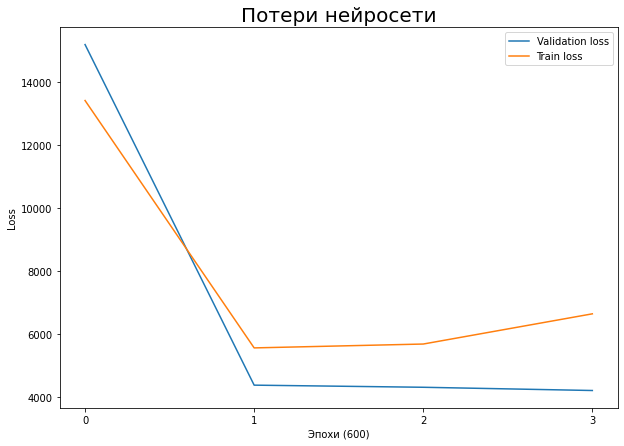

In [47]:
x = np.arange(len(val_loss))

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(7)
ax.set_xticks(x)
val = ax.plot(x, val_loss, label = 'Validation loss')
train = ax.plot(x, train_loss, label = 'Train loss')
ax.legend()
ax.set_title('Потери нейросети', fontsize=20)
ax.set_xlabel('Эпохи (600)')
ax.set_ylabel('Loss')
plt.show()

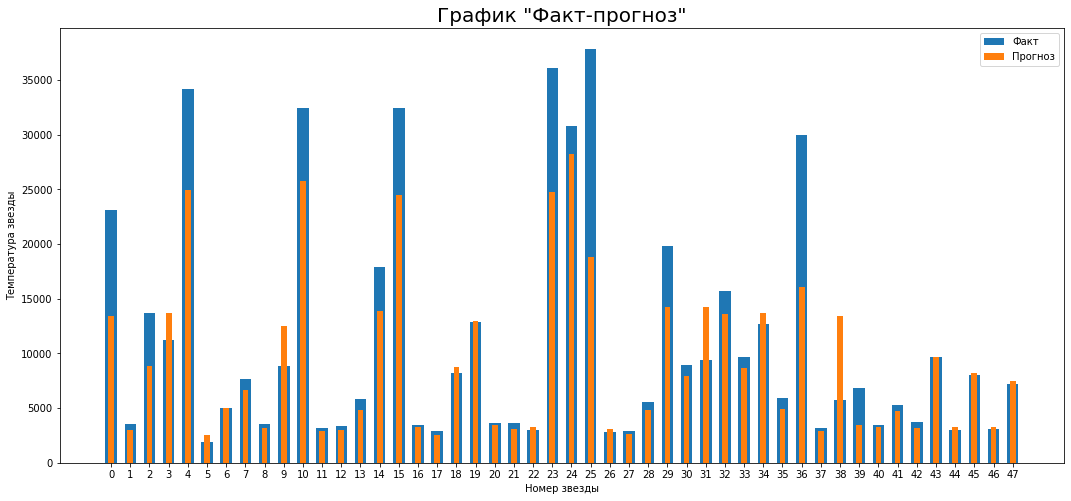

In [48]:
fact_forecast(predicted_temp, y_test)

### Вывод: 
1. Проведен перебор оптимизаторов. 
    Лучшим оптимизатором для этой задачи является NAdam с шагом равным одной сотой (RMSE = 4113). 
    На нём мы провели конечное улучшение модели: добавили dropout равный 50% и регуляризацию весов BatchNorm1d на первый скрытый слой. 
    Время обучения сильно увеличилась. Конечная метрика RMSE в улучшинной НС равна 4040. 
2. На графике видно, что модель обучилась качественно, без недо/переобучений. 
3. График фкт-прогноз схож с графиком от baseline.Видно, что модель предсказывает лучше до 15000 и свыше 30000 градусов по Кельвину.

## Выводы

1. Обзор данных и предобработка данных
    1. Набор данных содержит 6 признаков и 240 наблюдений. 

    2. Набор данных содержит 6 признаков:
        * Категориальные признаки:
            * `Star type`;
            * `Star color`.
        * Количественные признаки:
            * `Luminosity(L/Lo)`;
            * `Radius(R/Ro)`;
            * `Absolute magnitude(Mv)`.
        * Целевой признак -- `Temperature (K)`.

    3. Пропусков и явных дубликатов в данных нет. 
    
    4. По результатам предобработки данных были исправлены ошибки в столбце Star color, связанные с неявными дубликатами в словах, что позволило сократить количество уникальных значений с 19 до 12 штук.

2. Построение базовой нейронной сети
    1. Обучена baseline модель без перебора параметров.
    2. Лучшая метрика RMSE до начала переобучения равна 4268.

3. Улучшение нейронной сети

    1. Проведен перебор оптимизаторов. Лучшим оптимизатором для этой задачи является NAdam с шагом равным одной сотой (RMSE = 4113). На нём мы провели конечное улучшение модели: добавили dropout равный 50% и регуляризацию весов BatchNorm1d на первый скрытый слой. Время обучения сильно увеличилась. Конечная метрика RMSE в улучшинной НС равна 4040.
    2. На графике видно, что модель обучилась качественно, без недо/переобучений.
    3. График фкт-прогноз схож с графиком от baseline.Видно, что модель предсказывает лучше до 15000 и свыше 30000 градусов по Кельвину.
